# Анализ отзывов отелей
## Прогнозирование удовлетворенности гостей и выявление ключевых факторов

---



## 1. Введение и Постановка задачи
### Бизнес-контекст
Для отелей и платформ бронирования понимание факторов, влияющих на удовлетворенность гостей, критически важно. Этот проект анализирует отзывы, чтобы выявить ключевые драйверы удовлетворенности и построить модель прогнозирования оценок.

**Основные вопросы:**
- Какие аспекты (персонал, чистота, удобства) больше всего влияют на общую оценку?
- Как демографические характеристики гостей влияют на их оценки?
- Можно ли предсказать оценку отеля на основе его характеристик и профиля гостя?

**Методы:** EDA, статистический анализ, машинное обучение (регрессия), интерпретация моделей.

---


## 2. Настройка окружения

In [1]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Машинное обучение
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.inspection import permutation_importance
from sklearn.impute import SimpleImputer

# Статистика
from scipy import stats
from scipy.stats import ttest_ind, f_oneway

import warnings
warnings.filterwarnings('ignore')

# Настройка стилей для визуализаций
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
%matplotlib inline

---

## 3. Загрузка данных из SQLite базы

In [2]:
def load_data_from_db(db_path):
    """
    Загружает данные из SQLite базы данных
    """
    try:
        # Подключаемся к базе данных
        conn = sqlite3.connect(db_path)
        
        # Загружаем таблицы в DataFrame
        hotels_df = pd.read_sql_query("SELECT * FROM hotels", conn)
        reviews_df = pd.read_sql_query("SELECT * FROM reviews", conn)
        users_df = pd.read_sql_query("SELECT * FROM users", conn)
        
        conn.close()
        
        print(f"    Данные успешно загружены:")
        print(f"   - Hotels: {hotels_df.shape}")
        print(f"   - Reviews: {reviews_df.shape}")
        print(f"   - Users: {users_df.shape}")
        
        return hotels_df, reviews_df, users_df
        
    except Exception as e:
        print(f"Ошибка при загрузке данных: {e}")
        return None, None, None

# Загружаем данные
db_path = "booking_db.sqlite"  # укажите путь к данным
hotels, reviews, users = load_data_from_db(db_path)

    Данные успешно загружены:
   - Hotels: (25, 13)
   - Reviews: (50000, 12)
   - Users: (2000, 6)


---

## 4. Первичный осмотр данных

In [3]:
def explore_dataframe(df, name="DataFrame"):
    """
    Функция для первичного осмотра данных одного DataFrame.
    
    Параметры:
    - df: pandas.DataFrame — DataFrame для анализа.
    - name: str — имя таблицы или описание для удобства чтения.
    """
    print(f" ПЕРВИЧНЫЙ ОСМОТР ДАННЫХ: {name.upper()}")
    print("=" * 50)
    
    # Вывод первых строк
    print("\nПервые 3 строки:")
    print(df.head(3))
    
    # Информация о таблице
    print("\nИнформация о таблице:")
    df.info()
    
    # Статистика числовых столбцов
    print("\nСтатистика числовых столбцов:")
    print(df.describe())

In [4]:
# Исследуем hotels
explore_dataframe(hotels, name="Hotels")

 ПЕРВИЧНЫЙ ОСМОТР ДАННЫХ: HOTELS

Первые 3 строки:
   hotel_id         hotel_name      city         country  star_rating  \
0         1    The Azure Tower  New York   United States            5   
1         2  The Royal Compass    London  United Kingdom            5   
2         3    L'Étoile Palace     Paris          France            5   

       lat      lon  cleanliness_base  comfort_base  facilities_base  \
0  40.7580 -73.9855               9.1           8.8              8.9   
1  51.5072  -0.1276               9.0           9.2              8.8   
2  48.8566   2.3522               8.8           9.4              8.7   

   location_base  staff_base  value_for_money_base  
0            9.5         8.6                   8.0  
1            9.4         9.0                   7.9  
2            9.6         9.3                   8.1  

Информация о таблице:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 13 columns):
 #   Column                No

In [5]:
# Исследуем reviews
explore_dataframe(reviews, name = "Rewiews")

 ПЕРВИЧНЫЙ ОСМОТР ДАННЫХ: REWIEWS

Первые 3 строки:
   review_id  user_id  hotel_id review_date  score_overall  score_cleanliness  \
0          1     1600         1  2022-10-07            8.7                8.6   
1          2      432         4  2020-03-24            9.1               10.0   
2          3      186        18  2023-12-18            8.8                9.7   

   score_comfort  score_facilities  score_location  score_staff  \
0            8.7               8.5             9.0          8.8   
1            9.1               9.0             8.6          9.4   
2            8.8               8.3             8.7          8.1   

   score_value_for_money                                        review_text  
0                    8.7  Practice reduce young our because machine. Rec...  
1                    8.6  Test cover traditional black. Process tell Mr ...  
2                    8.6  Friend million student social study yeah. Grow...  

Информация о таблице:
<class 'pandas.core

In [6]:

# Исследуем users
explore_dataframe(users, name="Users")

 ПЕРВИЧНЫЙ ОСМОТР ДАННЫХ: USERS

Первые 3 строки:
   user_id user_gender         country age_group traveller_type   join_date
0        1      Female  United Kingdom     35-44           Solo  2024-09-29
1        2        Male  United Kingdom     25-34           Solo  2023-11-29
2        3      Female          Mexico     25-34         Family  2022-04-03

Информация о таблице:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   user_id         2000 non-null   int64 
 1   user_gender     2000 non-null   object
 2   country         2000 non-null   object
 3   age_group       2000 non-null   object
 4   traveller_type  2000 non-null   object
 5   join_date       2000 non-null   object
dtypes: int64(1), object(5)
memory usage: 93.9+ KB

Статистика числовых столбцов:
           user_id
count  2000.000000
mean   1000.500000
std     577.494589
min    

---

## 5. Проверка на пропуски и дубликаты

In [7]:
def check_data_quality(df, name):
    """
    Проверка качества данных для одного DataFrame.

    Параметры:
    - df: pandas.DataFrame — DataFrame для анализа.
    - name: str — имя таблицы или описание для удобства чтения.
    """

    print(f"ПРОВЕРКА КАЧЕСТВА ДАННЫХ: {name.upper()}")
    print("=" * 50)

    # Размер данных 
    print(f"\n{name}")
    print(f"    Размер: {df.shape}")

    # Проверка на пропуски 
    print(f"    Пропуски: {df.isnull().sum().sum()}")
    if df.isnull().sum().sum() > 0:
        print(f"    Столбцы с пропусками:")
        for col in df.columns:
            null_count = df[col].isnull().sum()
            if null_count > 0:
                print(f"    -{col}: {null_count} ({null_count / len(df) * 100:.2f}%)")

    # Проверка на дубликаты
    print(f"   Дубликаты: {df.duplicated().sum()}")
    
    # Проверка уникальных значений ключевых столбцов
    key_columns = ['hotel_id', 'review_id', 'user_id']
    for col in key_columns:
        if col in df.columns:
            print(f"   Уникальных значений в '{col}': {df[col].nunique()}")

In [8]:
check_data_quality(hotels, name="Hotels")

ПРОВЕРКА КАЧЕСТВА ДАННЫХ: HOTELS

Hotels
    Размер: (25, 13)
    Пропуски: 0
   Дубликаты: 0
   Уникальных значений в 'hotel_id': 25


In [9]:
check_data_quality(reviews, name="Reviews")

ПРОВЕРКА КАЧЕСТВА ДАННЫХ: REVIEWS

Reviews
    Размер: (50000, 12)
    Пропуски: 0
   Дубликаты: 0
   Уникальных значений в 'hotel_id': 25
   Уникальных значений в 'review_id': 50000
   Уникальных значений в 'user_id': 2000


In [10]:
check_data_quality(users, name="Users")

ПРОВЕРКА КАЧЕСТВА ДАННЫХ: USERS

Users
    Размер: (2000, 6)
    Пропуски: 0
   Дубликаты: 0
   Уникальных значений в 'user_id': 2000


---

## 6. Объединение данных

In [11]:
hotels.head(
    
)

,hotel_id,hotel_name,city,country,star_rating,lat,lon,cleanliness_base,comfort_base,facilities_base,location_base,staff_base,value_for_money_base
0,1,The Azure Tower,New York,United States,5,40.7580,-73.9855,9.1,8.8,8.9,9.5,8.6,8.0
1,2,The Royal Compass,London,United Kingdom,5,51.5072,-0.1276,9.0,9.2,8.8,9.4,9.0,7.9
2,3,L'Étoile Palace,Paris,France,5,48.8566,2.3522,8.8,9.4,8.7,9.6,9.3,8.1
3,4,Kyo-to Grand,Tokyo,Japan,5,35.6895,139.6917,9.6,9.0,9.3,8.5,9.5,8.2
4,5,The Golden Oasis,Dubai,United Arab Emirates,5,25.2769,55.2962,9.3,9.5,9.6,8.9,9.4,8.5


In [12]:
reviews.head()

,review_id,user_id,hotel_id,review_date,score_overall,score_cleanliness,score_comfort,score_facilities,score_location,score_staff,score_value_for_money,review_text
0,1,1600,1,2022-10-07,8.7,8.6,8.7,8.5,9.0,8.8,8.7,Practice reduce young our because machine. Rec...
1,2,432,4,2020-03-24,9.1,10.0,9.1,9.0,8.6,9.4,8.6,Test cover traditional black. Process tell Mr ...
2,3,186,18,2023-12-18,8.8,9.7,8.8,8.3,8.7,8.1,8.6,Friend million student social study yeah. Grow...
3,4,1403,19,2022-06-22,8.9,9.0,8.8,8.5,9.6,9.1,8.3,Huge girl already remain truth behind card. Ap...
4,5,1723,17,2022-07-02,9.1,8.9,9.5,9.3,8.3,9.4,8.9,Cover feeling call community serve television ...


In [13]:
def merge_datasets(hotels, reviews, users):
    """
    Объединяет все три таблицы в один DataFrame
    """

    print(" ОБЪЕДИНЕНИЕ ДАННЫХ")
    print("=" * 50)

    # Объединяем reviews с hotels 
    df = pd.merge(reviews, hotels, on = 'hotel_id', how='left', suffixes=('_review', '_hotel'))
    print(f"После объединения Reviews + Hotels: {df.shape}")

    # Объединяем с users
    df = pd.merge(df, users, on='user_id', how='left')
    print(f"После объединения с Users: {df.shape}")
    # Проверяем результат
    print(f"\nИтоговый размер объединенного датасета: {df.shape}")
    print(f"Колонки: {list(df.columns)}")
    
    return df

# Создаем объединенный датасет
df = merge_datasets(hotels, reviews, users)



 ОБЪЕДИНЕНИЕ ДАННЫХ
После объединения Reviews + Hotels: (50000, 24)
После объединения с Users: (50000, 29)

Итоговый размер объединенного датасета: (50000, 29)
Колонки: ['review_id', 'user_id', 'hotel_id', 'review_date', 'score_overall', 'score_cleanliness', 'score_comfort', 'score_facilities', 'score_location', 'score_staff', 'score_value_for_money', 'review_text', 'hotel_name', 'city', 'country_x', 'star_rating', 'lat', 'lon', 'cleanliness_base', 'comfort_base', 'facilities_base', 'location_base', 'staff_base', 'value_for_money_base', 'user_gender', 'country_y', 'age_group', 'traveller_type', 'join_date']


## 7. Предобработка данных и Feature Engineering

In [14]:
from src.data_preprocessing import preprocess_and_feature_engineering

# Используем функцию из src
df_processed = preprocess_and_feature_engineering(df)

 ПРЕДОБРАБОТКА ДАННЫХ И FEATURE ENGINEERING
Добавлены временные признаки
Добавлен cleanliness_gap
Добавлен comfort_gap
Добавлен facilities_gap
 Добавлены агрегированные признаки отеля
    Итоговый размер после обработки: (50000, 44)
    Новые колонки: ['review_year', 'review_month', 'review_day', 'review_dayofweek', 'season', 'cleanliness_gap', 'comfort_gap', 'facilities_gap', 'hotel_avg_score', 'hotel_review_count', 'hotel_avg_cleanliness', 'hotel_avg_comfort', 'hotel_avg_staff', 'total_specific_scores', 'score_variance']


## 8. Разведочный анализ данных (EDA)

### 8.1 Распределение целевой переменной

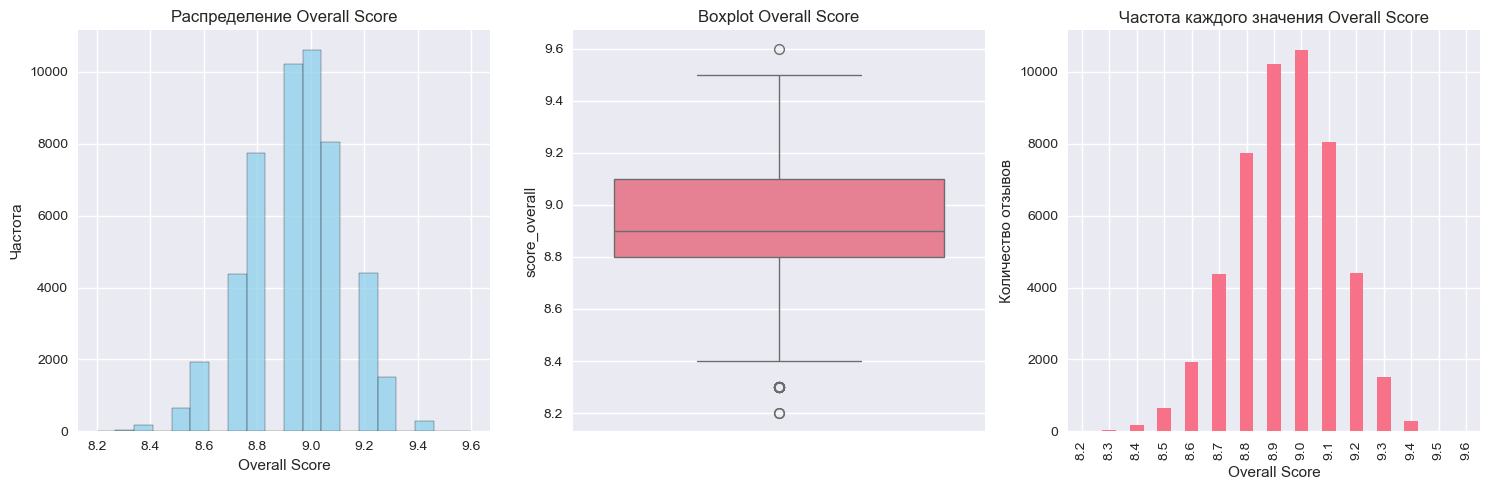

    Статистики Overall Score:
   Среднее: 8.94
   Медиана: 8.90
   Стандартное отклонение: 0.18
   Минимум: 8.20
   Максимум: 9.60


In [18]:
plt.figure(figsize=(15, 5))


plt.subplot(1, 3, 1)
plt.hist(df_processed['score_overall'], bins=20, alpha=0.7, color='skyblue', edgecolor='black')
plt.title('Распределение Overall Score')
plt.xlabel('Overall Score')
plt.ylabel('Частота')

plt.subplot(1, 3, 2)
sns.boxplot(y=df_processed['score_overall'])
plt.title('Boxplot Overall Score')

plt.subplot(1, 3, 3)
df_processed['score_overall'].value_counts().sort_index().plot(kind='bar')
plt.title('Частота каждого значения Overall Score')
plt.xlabel('Overall Score')
plt.ylabel('Количество отзывов')

plt.tight_layout()
plt.show()

print(f"    Статистики Overall Score:")
print(f"   Среднее: {df_processed['score_overall'].mean():.2f}")
print(f"   Медиана: {df_processed['score_overall'].median():.2f}")
print(f"   Стандартное отклонение: {df_processed['score_overall'].std():.2f}")
print(f"   Минимум: {df_processed['score_overall'].min():.2f}")
print(f"   Максимум: {df_processed['score_overall'].max():.2f}")

### 8.2 Анализ распределения оценок по категориям

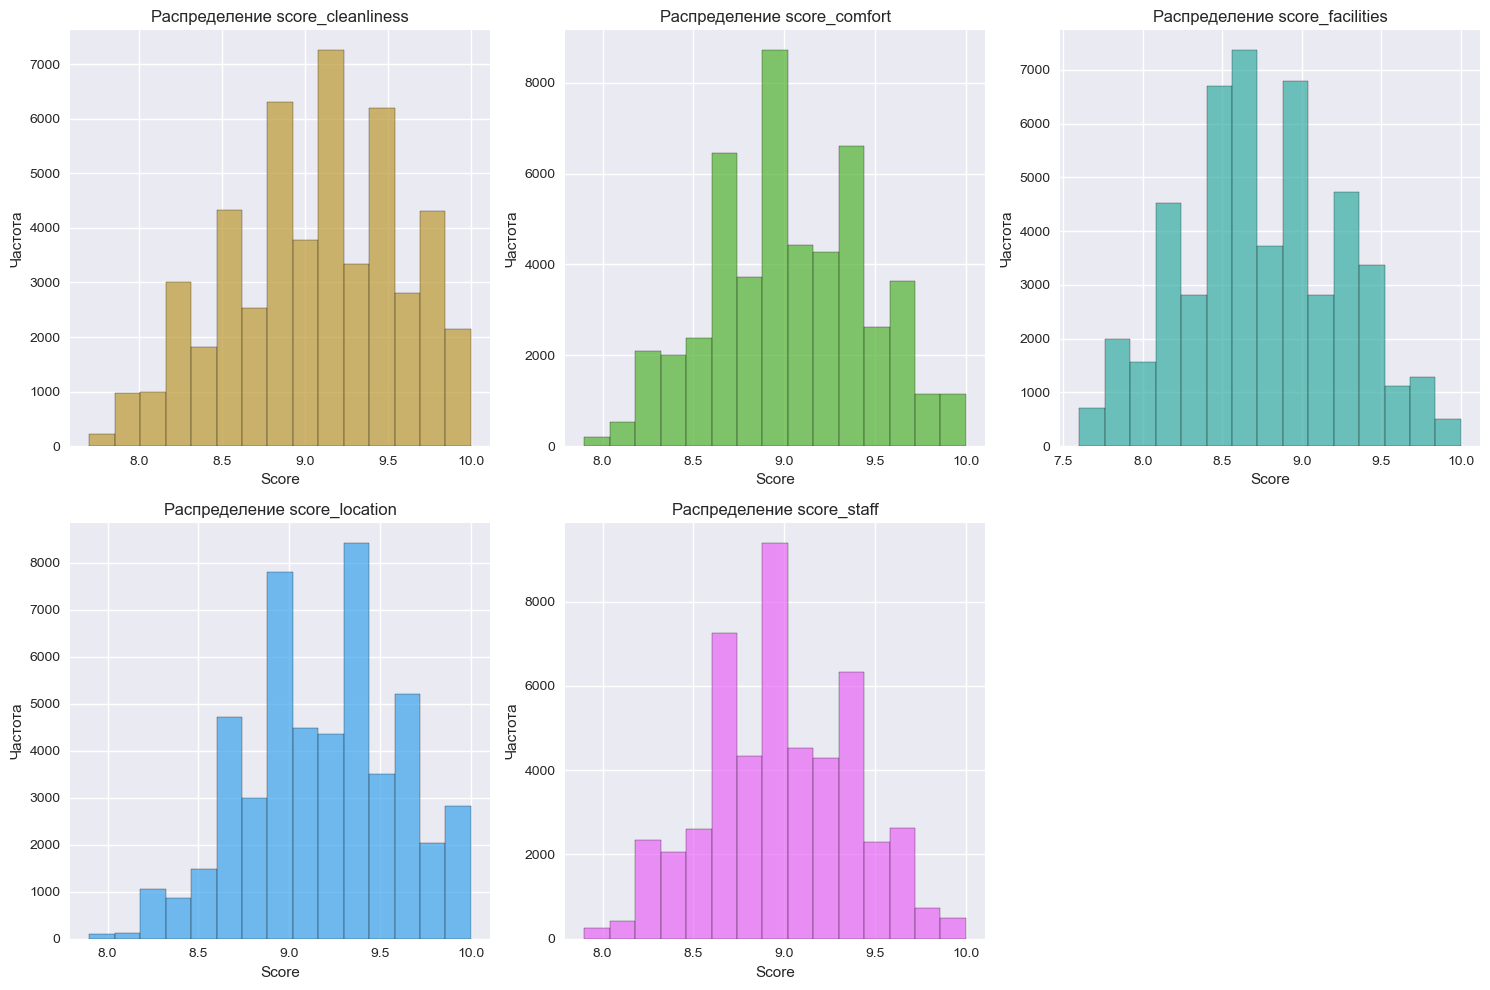

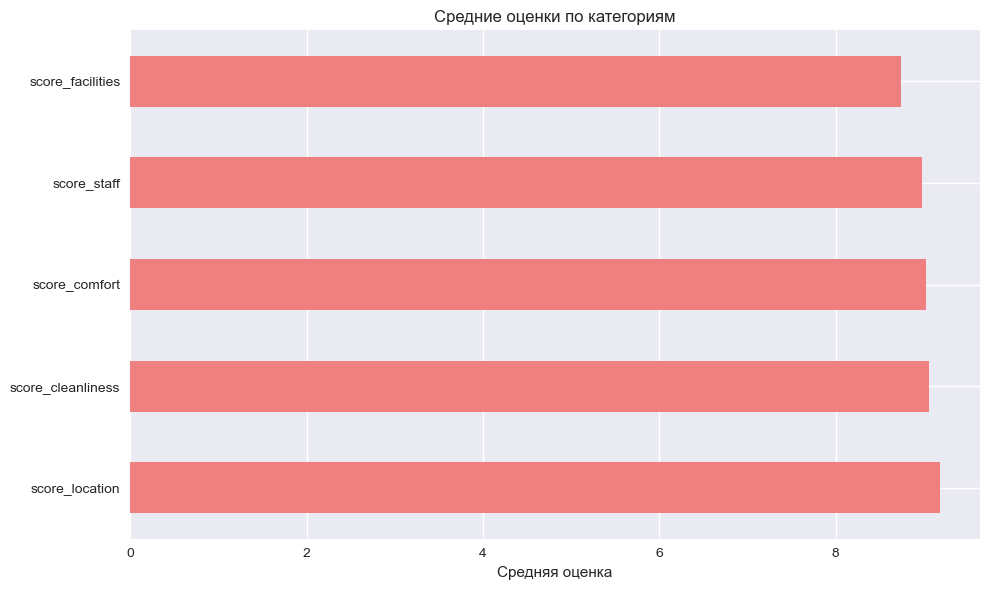

In [19]:
specific_scores = ['score_cleanliness', 'score_comfort', 'score_facilities', 'score_location', 'score_staff']

plt.figure(figsize=(15, 10))
for i, score in enumerate(specific_scores, 1):
    plt.subplot(2, 3, i)
    plt.hist(df_processed[score], bins=15, alpha=0.7, color=f'C{i}', edgecolor='black')
    plt.title(f'Распределение {score}')
    plt.xlabel('Score')
    plt.ylabel('Частота')

plt.tight_layout()
plt.show()

# Сравнение средних оценок по категориям
avg_scores = df_processed[specific_scores].mean().sort_values(ascending=False)
plt.figure(figsize=(10, 6))
avg_scores.plot(kind='barh', color='lightcoral')
plt.title('Средние оценки по категориям')
plt.xlabel('Средняя оценка')
plt.tight_layout()
plt.show()